# Previsão do valor do convênio médico

Neste projeto, vamos explorar um conjunto de dados que contém informações sobre o perfil de clientes e os valores de convênio médico associados a eles.

Nosso objetivo é construir um modelo de regressão capaz de prever o valor do convênio médico com base nas características dos clientes.

## Análise exploratória de dados

Vamos começar importando as bibliotecas necessárias e carregando os dados.

In [111]:
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

! pip install plotly_express
import plotly_express as px

import warnings
warnings.filterwarnings("ignore")

In [112]:
dados = pd.read_csv("https://drive.google.com/uc?id=1x3TepqSt5_ZKq0KomcjwkgyPxaa4TrWi")
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Shape dos dados:

In [113]:
dados.shape

(1338, 7)

Verificação de valores nulos:

In [114]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Descrição estatística dos dados:

In [115]:
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Pré-processamento dos dados

Antes de construir nosso modelo, realizamos algumas etapas de pré-processamento, como codificação de variáveis categóricas e escalonamento de características numéricas.

In [116]:
colunas=['sex','smoker','region']

label_encoder = LabelEncoder()
for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


## Análise visual dos dados

Para entender melhor a relação entre algumas variáveis e o valor do convênio médico, realizamos algumas visualizações.

Gráfico de correlação:

<Axes: >

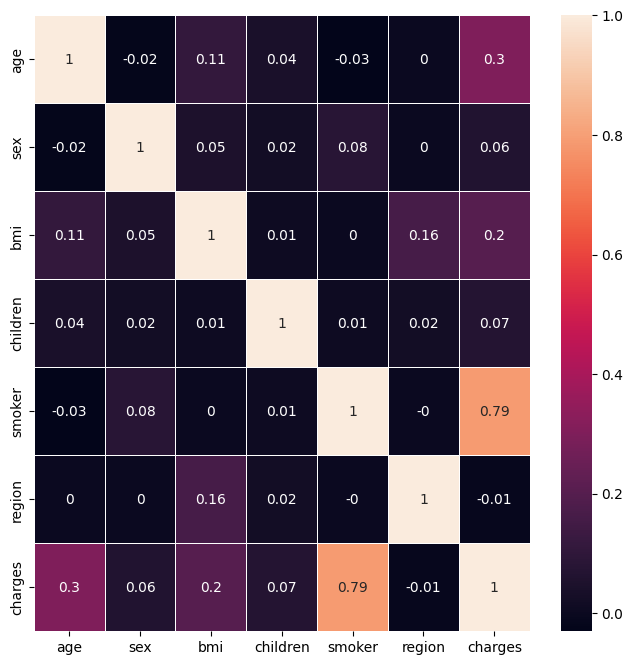

In [117]:
correlation_matrix = dados.corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

# Relação de fumantes e Custo do convênio médico

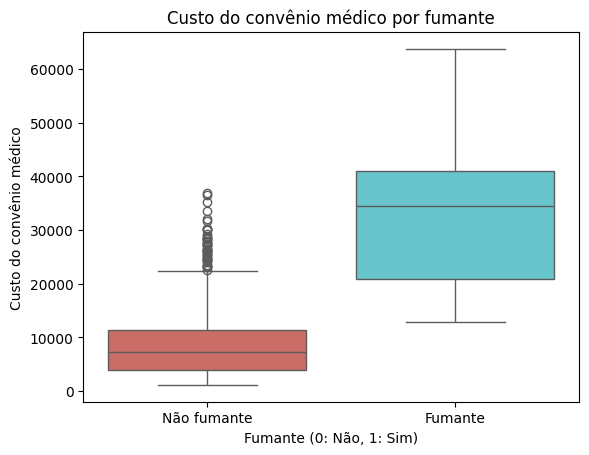

In [118]:
sb.boxplot(x='smoker', y='charges', data=dados, palette='hls')
plt.title('Custo do convênio médico por fumante')
plt.xlabel('Fumante (0: Não, 1: Sim)')
plt.ylabel('Custo do convênio médico')
plt.xticks([0, 1], ['Não fumante', 'Fumante'])
plt.show()

Após analisarmos a correlação entre Valor de convênio e se o paciente é fumante (0.79), podemos confirmar que o fato de ser fumante irá contribuir com o custo do convênio médico (Nossa variável Target).

# Relação de número de filhos e Custo do convênio médico

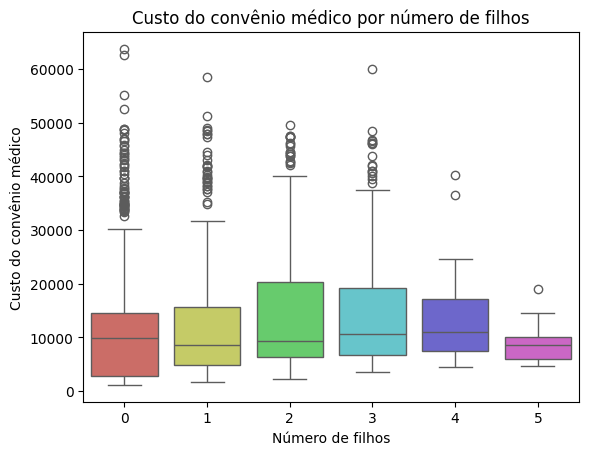

In [119]:
sb.boxplot(x='children', y='charges', data=dados, palette='hls')
plt.title('Custo do convênio médico por número de filhos')
plt.xlabel('Número de filhos')
plt.ylabel('Custo do convênio médico')
plt.show()

Após visualização do boxplot acima, concluímos que não há referência significativa da quantidade de filhos com o valor de custo do convênio, dado que pode ser confirmado pelo gráfico de correlação das variáveis, trazendo uma correlação entre ambos de 0.07.

# Violin Plot de preço do convênio por região e sexo:

In [120]:
fig = px.violin(dados, y="charges", x="region", color="sex",
                box=True, points="all",
                labels={"charges": "Custo do convênio médico",
                        "region": "Região",
                        "sex": "Sexo"})
fig.show()

# Distribuição da idade dos pacientes

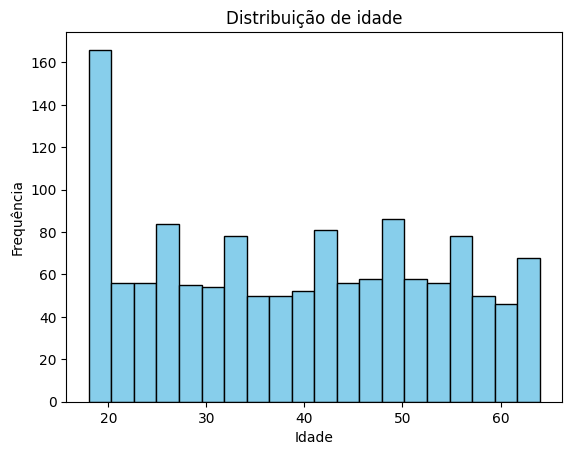

In [121]:
plt.hist(dados['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

# Relação entre índice de massa corporal (IMC) e custo do convênio médico:

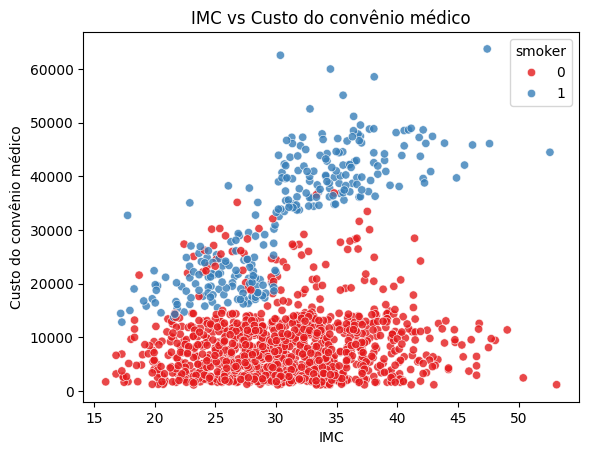

In [122]:
sb.scatterplot(x='bmi', y='charges', hue='smoker', data=dados, palette='Set1', alpha=0.8)
plt.title('IMC vs Custo do convênio médico')
plt.xlabel('IMC')
plt.ylabel('Custo do convênio médico')
plt.show()

O IMC não tem uma interferência significante no custo, podemos notar diversos pacientes com o mesma faixa de IMC, porém totalmente diferentes na escala de custo.

# Relação entre idade e custo do convênio médico, com diferenciação entre fumantes e não fumantes:


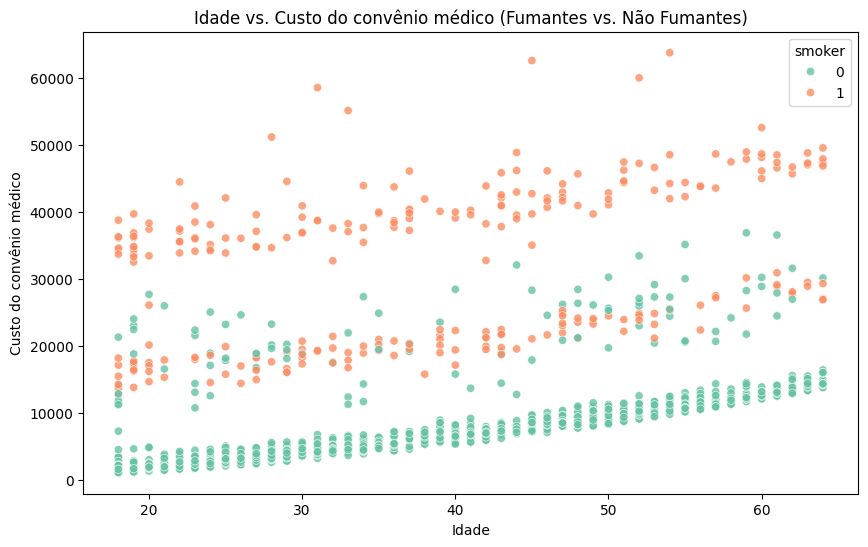

In [123]:
plt.figure(figsize=(10, 6))
sb.scatterplot(x='age', y='charges', hue='smoker', data=dados, palette='Set2', alpha=0.8)
plt.title('Idade vs. Custo do convênio médico (Fumantes vs. Não Fumantes)')
plt.xlabel('Idade')
plt.ylabel('Custo do convênio médico')
plt.show()

Validando as informações acima, é possível notar que a idade não tem inflência no Custo do convênio, tudo indicando ao "Ser fumante", ser o maior fator.

# Validando a correlação de todas as características com o custo do convênio médico

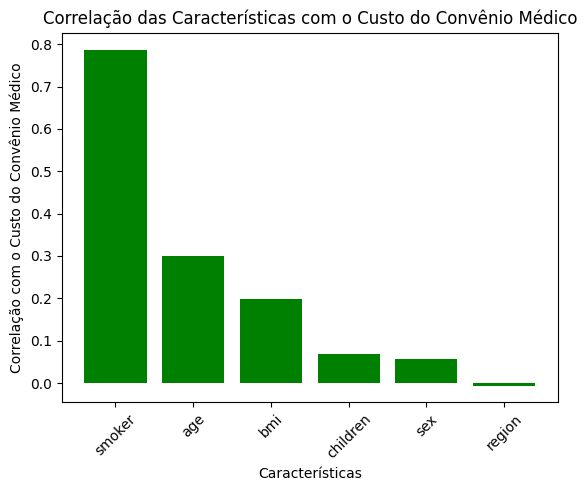

In [124]:
correlation_with_target = dados.corr()['charges'].sort_values(ascending=False)
correlation_with_target = correlation_with_target.drop('charges')  # Remove a correlação com ela mesma

plt.bar(correlation_with_target.index, correlation_with_target, color='green')
plt.title('Correlação das Características com o Custo do Convênio Médico')
plt.xlabel('Características')
plt.ylabel('Correlação com o Custo do Convênio Médico')
plt.xticks(rotation=45)
plt.show()

## Construção do modelo de regressão

Neste projeto, utilizamos o algoritmo de regressão dos k-vizinhos mais próximos (KNN) para prever o custo do convênio médico.

Separando as features e o target:

In [125]:
x = dados[['age', 'sex', 'bmi', 'children', 'smoker','region']]
y = dados['charges']

# Dividindo os dados em conjuntos de treinamento e teste:

In [126]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7,)

# Escalonando as características:

In [127]:
scaler = StandardScaler()

scaler.fit(X_train)

x_train_standard_scaled = scaler.transform(X_train)
x_test_standard_scaled  = scaler.transform(X_test)

## Escolha do Número de Vizinhos para o Modelo KNN

Nesta etapa, vamos determinar o número ideal de vizinhos (K) para o modelo de regressão dos k-vizinhos mais próximos (KNN). Isso será feito avaliando o erro médio quadrático (RMSE) para diferentes valores de K.

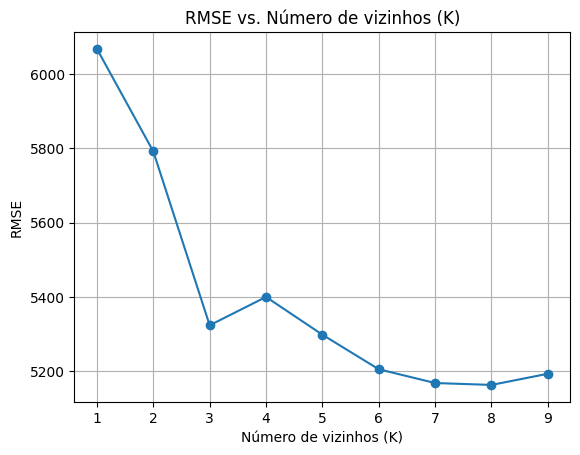

In [128]:
k_values = range(1, 10)

rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_standard_scaled, y_train)
    y_pred = knn.predict(x_test_standard_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

plt.plot(k_values, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs. Número de vizinhos (K)')
plt.xlabel('Número de vizinhos (K)')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.grid(True)
plt.show()

No gráfico, a linha de RMSE em relação ao número de vizinhos (K) mostra que o RMSE é mais baixo em torno dos valores de 7 e 8. Portanto, o número ideal de vizinhos escolhido para o modelo é 7.

Essa escolha é crucial, pois afeta diretamente o desempenho do modelo. Optar por um número adequado de vizinhos pode ajudar a evitar overfitting ou underfitting e melhorar a capacidade do modelo de generalizar para novos dados.

Construindo e treinando o modelo KNN:

In [129]:
model = KNeighborsRegressor(n_neighbors=7)

model.fit(x_train_standard_scaled, y_train)

KNeighborsRegressor(n_neighbors=7)

Fazendo previsões:

In [130]:
y_pred = model.predict(x_test_standard_scaled)

Avaliando o modelo:

In [131]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R^2): {r2:.2f}')

R-squared (R^2): 0.83


# Resultados e Insights

O coeficiente de determinação (R^2) do modelo de regressão KNN foi calculado como 0.83, o que indica que aproximadamente 83% da variabilidade observada nos custos do convênio médico pode ser explicada pelas características dos clientes consideradas no modelo.

Este resultado sugere que o modelo tem uma boa capacidade de previsão dos custos do convênio médico com base nas características dos clientes. No entanto, ainda pode haver espaço para melhorias, como a inclusão de outras variáveis relevantes ou experimentação com diferentes algoritmos de regressão.

### **Com base na análise dos dados, concluímos que o custo do convênio médico não é predominantemente influenciado pela idade, mas sim pela condição de fumante. A correlação entre o hábito de fumar e o valor do convênio é significativa, representando aproximadamente 70% da variação nos custos, conforme indicado pela análise de correlação em nossa base de dados.**